## Open Issue Age
This is the reference implementation for [Open Issue Age](https://github.com/chaoss/wg-evolution/blob/master/metrics/issues-open-age.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Open Issue Age
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import numpy as np
from code_df import utils
from code_df.issue import Issue
%matplotlib inline

In [2]:
class OpenIssueAge(Issue):

    def __init__(self, data_list, date_range=(None, None)):
        """
        Class for Age of Open Issues

        :param data_list: A list of dictionaries, each element a line from the
            JSON file
        :param date_range: A tuple which represents the start and end date of
            interest
        """
        super().__init__(data_list, date_range)

        self.df = self._add_open_issue_age_col(self.df)

    def compute(self):
        """
        Compute the average open issue age for all issues in the Perceval data.

        :returns avg_open_issue_ages: the average age of open
            issues
        """

        open_issue_ages = [age for age in self.df['open_issue_age']
                           if not pd.isna(age)]

        avg_open_issue_ages = np.mean(open_issue_ages)
        return avg_open_issue_ages

    def compute_timeseries(self, period="month"):
        """
        The metric value is computed for each fixed interval of time
        from the "since" date to the "until" date arguments, specified
        during object initiation.
        The fixed time interval can be either a month or a week.

        :param period: A string which can be either "month" or "week"

        :returns dataframe: A DataFrame whose rows each represent an interval
            of "period" and the count for that interval
        """

        if self.since is None:
            self.since = utils.get_date(self.df, 'since')
        if self.until is None:
            self.until = utils.get_date(self.df, 'until')

        df = self.df
        if period == "month":
            timeseries_series = df[['created_date', 'open_issue_age']]  \
                .groupby([df['created_date'].dt.year.rename('year'),
                          df['created_date'].dt.month.rename('month')]) \
                .agg('mean')

            all_periods = pd.DataFrame(
                pd.date_range(self.since, self.until, freq='M'),
                columns=["Dates"])

            all_periods = pd.DataFrame(
                [all_periods['Dates'].dt.year.rename("year"),
                 all_periods['Dates'].dt.month.rename("month")]).T

        elif period == "week":
            timeseries_series = df[['created_date', 'open_issue_age']]  \
                .groupby([df['created_date'].dt.year.rename('year'),
                          df['created_date'].dt.week.rename('week')]) \
                .agg('mean')

            all_periods = pd.DataFrame(
                pd.date_range(self.since, self.until, freq='W'),
                columns=["Dates"])

            all_periods = pd.DataFrame(
                [all_periods['Dates'].dt.year.rename("year"),
                 all_periods['Dates'].dt.week.rename("week")]).T

        else:
            raise ValueError("period parameter can take 'month' or 'week'")

        timeseries_df = pd.DataFrame(timeseries_series)
        timeseries_df.reset_index(inplace=True)
        timeseries_df.columns = ["year", period, "open_issue_age"]
        timeseries_df['open_issue_age'] = timeseries_df['open_issue_age'].round(decimals=2)
        merged_df = all_periods.merge(timeseries_df, how='outer').fillna(0)

        dataframe = merged_df
        return dataframe

    def _add_open_issue_age_col(self, df):
        """
        Adds the open_issue_age column to df if it has data.

        :param df: A pandas DataFrame.
        :returns df: Modified DataFrame

        :raises ValueError: No analysis possible if no valid data in df.
        """

        if len(df) > 0:
            # add open_issue_age column
            df['open_issue_age'] = pd.np.nan

            # replace NaN values for open issues by their "age"
            issue_status_series = datetime.now() - df["created_date"][
                df["current_status"] == "open"]

            ages_in_days = [x.days for x in issue_status_series]
            df.loc[df["current_status"] == "open",
                   ['open_issue_age']] = ages_in_days

        else:
            raise ValueError("DataFrame empty. "
                             "Please check instantiation parameters")

        return df


## Performing the Analysis
We'll perform two kinds of analysis here:
- Counting the average age of open issues
- Change of average open issue age over time

### Counting the average age of open issues
First, we read the JSON file `issues.json`, present in the `implementations` directory, one level up. We make use of the `read_JSON_file` utility function. 

In [3]:
items = utils.read_JSON_file('../issues.json')

Let's use the `compute` method to count the total number of valid commits made. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.   

Lets calculate the average age for all open issues first. Then, we can do it by passing a start date. Here, only those issues will be considered that were created after the start date we passed via the variable `date_since`. 

While printing the output, we will keep the precision to only two decimals. 

In [4]:
date_since = datetime.strptime("2018-09-07", "%Y-%m-%d")
open_issue_age = OpenIssueAge(items)
print("The average age of all open issues is {:.2f} days."
      .format(open_issue_age.compute()))

open_issue_age_interval = OpenIssueAge(items, (date_since, None))
print("The average age of open issues created after 2018-09-07 is {:.2f} days."
      .format(open_issue_age_interval.compute()))

The average age of all open issues is 503.42 days.
The average age of open issues created after 2018-09-07 is 191.26 days.


## Average age of open issues over time
Using the `compute_timeseries` method, we can see how the average age of open issues changes on a weekly or monthly basis.  This kind of analysis is useful in finding trends over time, as we will see in the cell below.

Lets use the `open_issue_age_interval` object we created above, where we passed an opening date to the object via `date_since`.

In [5]:
weekly_df = open_issue_age_interval.compute_timeseries("week")

Lets see what the dataframe returned by `compute_timeseries` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. A simple merge between the dataframes of all possible weeks and the commit count dataframe (which would of course, be missing several rows(weeks) where there would be no commits) gave us this output. 

In [6]:
weekly_df

,year,week,open_issue_age
0,2018,36,289.00
1,2018,37,0.00
2,2018,38,0.00
3,2018,39,267.00
4,2018,40,0.00
5,2018,41,0.00
6,2018,42,0.00
7,2018,43,239.00
8,2018,44,0.00
9,2018,45,0.00


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple line plot --- commit count vs time interval. Using the `plt.fill_between` method allows us to "fill up" the area between the line plot and the x axis.

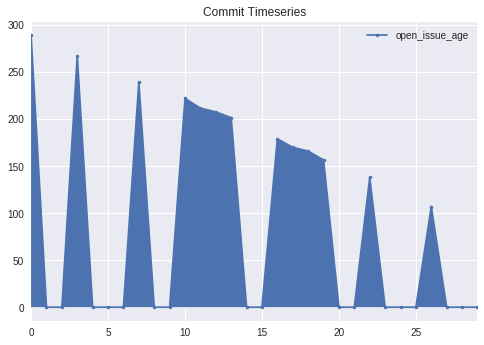

In [7]:
plt.style.use('seaborn')
weekly_df.plot(y='open_issue_age', use_index=True, marker='.')
plt.fill_between(y1=weekly_df['open_issue_age'], y2=0, x=weekly_df.index)
plt.title("Commit Timeseries");

The lows in the graph above mean that either no issues were created that week, or that all created issues were closed. 

Lets try and do the same thing, but this time, we'll do it on a monthy basis.

In [8]:
monthly_df = open_issue_age_interval.compute_timeseries("month")

In [9]:
monthly_df

,year,month,open_issue_age
0,2018,9,278.00
1,2018,10,239.00
2,2018,11,211.43
3,2018,12,197.00
4,2019,1,162.25
5,2019,2,138.00
6,2019,3,107.00


As predicted, the `monthly_df` dataframe has significantly lesser rows than the dataframe we just observed --- `weekly_df`. Each row corresponds to a month between the `since` and `until` finish dates we passed to while instantiating the `OpenIssueAge` class.  

Lets do one last thing: plot the graph for `monthly_df`. 

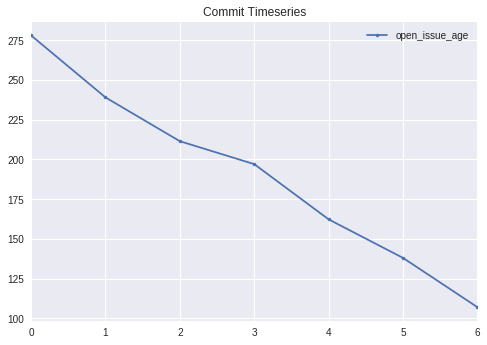

In [10]:
plt.style.use('seaborn')
monthly_df.plot(y='open_issue_age', use_index=True, marker='.')
plt.title("Commit Timeseries");